<a href="https://colab.research.google.com/github/PoliNemkova/AI-art-style/blob/main/LSTM_without_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and data


following this tutorial: https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
import os
import datetime as dt

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pandas_datareader import data
import urllib.request, json
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/PoliNemkova/crypto/5aa17c1d623cff982ecc6f52330c2bfb0c790b7e/bitcoin-covid19.csv')


In [ ]:
df.shape

(246, 37)

In [ ]:
print(df)
df.columns

     sum_new_cases  mean_new_cases  ...   sum_volume  mean_volume
0                1        1.000000  ...  9277.814487     6.442927
1                0        0.000000  ...  5054.642417     3.510168
2                3        3.000000  ...  7423.894835     5.159065
3                0        0.000000  ...  3561.372111     2.473175
4                0        0.000000  ...  3266.132200     2.268147
..             ...             ...  ...          ...          ...
241         214815      994.513889  ...  3592.170856     2.494563
242         253763     1174.828704  ...  2372.738603     1.647735
243         281802     1304.638889  ...  1861.620127     1.292792
244         286800     1327.777778  ...  4104.544299     2.852359
245         294194     1362.009259  ...  3602.563970     2.501781

[246 rows x 18 columns]


Index(['sum_new_cases', 'mean_new_cases', 'sum_cumulative_cases',
       'mean_cumulative_cases', 'sum_new_deaths', 'mean_new_deaths',
       'sum_cumulative_deaths', 'mean_cumulative_deaths', 'sum_open',
       'mean_open', 'sum_close', 'mean_close', 'sum_high', 'mean_high',
       'sum_low', 'mean_low', 'sum_volume', 'mean_volume'],
      dtype='object')

In [ ]:
##removing Covid data
#df = pd.read_csv('https://raw.githubusercontent.com/PoliNemkova/crypto/5aa17c1d623cff982ecc6f52330c2bfb0c790b7e/bitcoin-covid19.csv')



In [ ]:
df=df.drop(['sum_new_cases','mean_new_cases','sum_cumulative_cases','mean_cumulative_cases','sum_new_deaths','mean_new_deaths','sum_cumulative_deaths', 'mean_cumulative_deaths' ], axis=1)

# Dropping features of less importance (according to random forest and correlation)

In [ ]:
#dropping non sensitive features
df=df.drop(['date','skew_volume','kurt_volume','skew_low','kurt_low','kurt_high', 'skew_high', 'kurt_close',
       'skew_close','kurt_open', 'skew_open','kurt_cumulative_deaths',
       'skew_cumulative_deaths', 'kurt_new_deaths', 'skew_new_deaths',  'kurt_cumulative_cases',
       'skew_cumulative_cases', 'kurt_new_cases', 'skew_new_cases'], axis=1)

In [ ]:
#df.head()
#print(df)
df.columns

Index(['sum_new_cases', 'mean_new_cases', 'sum_cumulative_cases',
       'mean_cumulative_cases', 'sum_new_deaths', 'mean_new_deaths',
       'sum_cumulative_deaths', 'mean_cumulative_deaths', 'sum_open',
       'mean_open', 'sum_close', 'mean_close', 'sum_high', 'mean_high',
       'sum_low', 'mean_low', 'sum_volume', 'mean_volume'],
      dtype='object')

In [ ]:
#Adding new feature mean_price
df['mean_price']=(df['mean_high']+df['mean_low'])/2

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#Split the data
We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. 

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
print(train_df)

     sum_new_cases  mean_new_cases  ...  mean_volume   mean_price
0                1        1.000000  ...     6.442927  8025.971550
1                0        0.000000  ...     3.510168  7816.873071
2                3        3.000000  ...     5.159065  8061.896132
3                0        0.000000  ...     2.473175  8096.035403
4                0        0.000000  ...     2.268147  8111.510512
..             ...             ...  ...          ...          ...
167         142823      661.217593  ...     2.747214  9256.727764
168         140145      648.819444  ...     2.647252  9169.179220
169         184208      852.814815  ...     2.259627  9067.519119
170         153025      708.449074  ...     2.718333  9113.383759
171         132700      614.351852  ...     1.687966  9145.406095

[172 rows x 19 columns]


# Data normalization

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

In [ ]:
print(train_mean)

sum_new_cases             5.217597e+04
mean_new_cases            2.648052e+02
sum_cumulative_cases      2.207577e+06
mean_cumulative_cases     1.060302e+04
sum_new_deaths            2.715459e+03
mean_new_deaths           1.342990e+01
sum_cumulative_deaths     1.363089e+05
mean_cumulative_deaths    6.433639e+02
sum_open                  1.222535e+07
mean_open                 8.491234e+03
sum_close                 1.222532e+07
mean_close                8.491218e+03
sum_high                  1.222948e+07
mean_high                 8.494104e+03
sum_low                   1.222108e+07
mean_low                  8.488268e+03
sum_volume                1.011277e+04
mean_volume               7.023907e+00
mean_price                8.491186e+03
dtype: float64


In [ ]:
train_df = (train_df-train_mean)/train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#print(train_df)

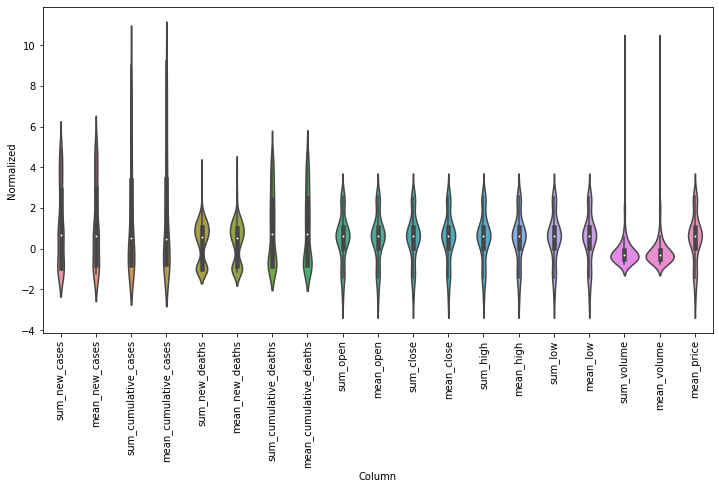

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data windowing

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=1,  #Poli changed from 24 1 24 to 5 1 5
                     label_columns=['mean_price'])
w1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['mean_price']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['mean_price'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['mean_price']

In [ ]:
#Converting  windows into a window of inputs and a window of labels.
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[10:10+w2.total_window_size]),######Poli changed 100 to 61 to 10 
                           np.array(train_df[20:20+w2.total_window_size])]) #######Poli changes 200 to 122 to 20


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Visualizing the data split

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='mean_price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  #plt.xlabel('date')   # removed since we removed the date

WindowGenerator.plot = plot

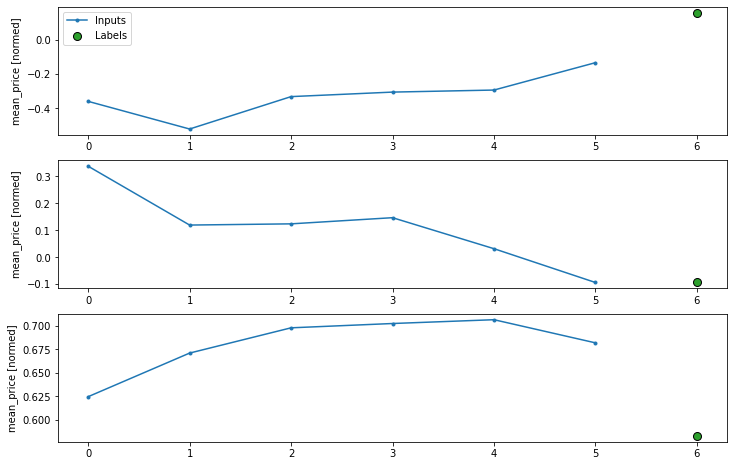

In [ ]:
w2.plot()

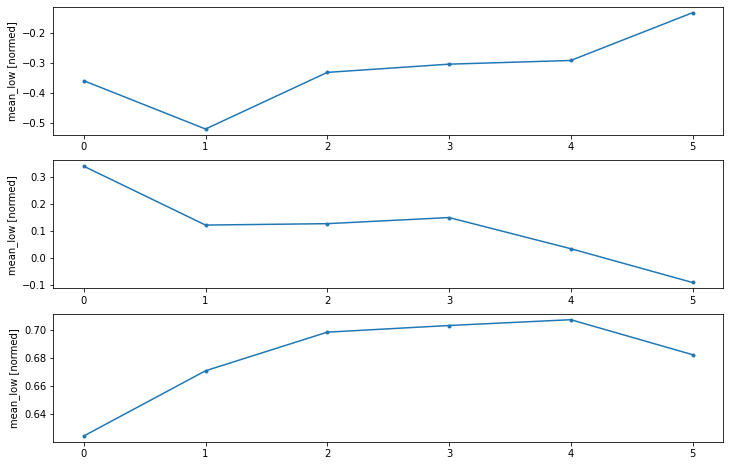

In [ ]:
w2.plot(plot_col='mean_low')

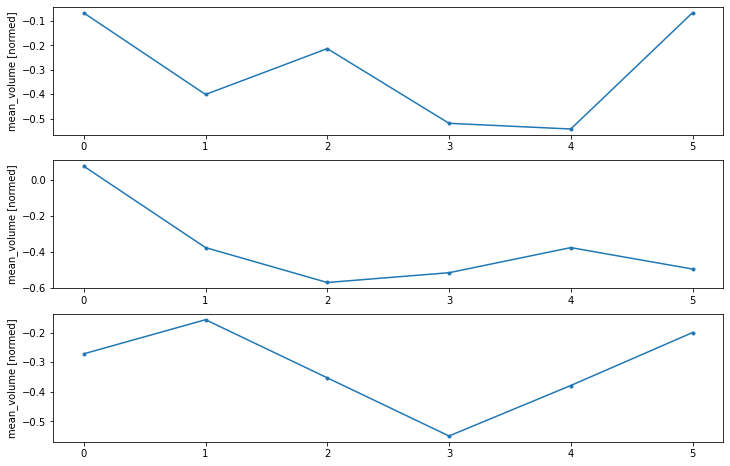

In [ ]:
w2.plot(plot_col='mean_volume')

#Create tf.data.Datasets

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=7,) #Poli changed batch size from 32 to 10 to 7

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (7, 6, 19)
Labels shape (batch, time, features): (7, 1, 1)


#Single step models

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['mean_price'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['mean_price']

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['mean_price'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['mean_price']

#Baseline

In [ ]:
##baseline
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['mean_price'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

7/7 [==============================] - 0s 2ms/step - loss: 0.0215 - mean_absolute_error: 0.1028


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['mean_price'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['mean_price']

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (7, 1, 19)
Output shape: (7, 1, 1)


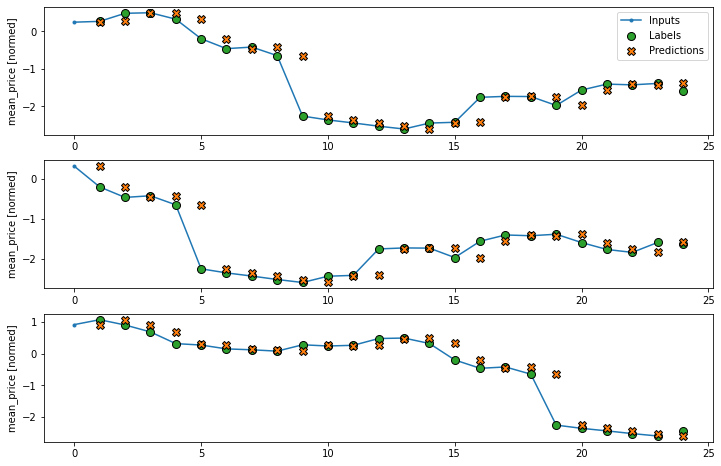

In [ ]:
wide_window.plot(baseline)

#Linear model

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (7, 1, 19)
Output shape: (7, 1, 1)


In [ ]:
MAX_EPOCHS = 20 

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
25/25 [==============================] - 0s 8ms/step - loss: 6.3673 - mean_absolute_error: 2.0892 - val_loss: 11.5322 - val_mean_absolute_error: 2.6498
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 5.1882 - mean_absolute_error: 1.8690 - val_loss: 7.3351 - val_mean_absolute_error: 2.0104
Epoch 3/20
25/25 [==============================] - 0s 3ms/step - loss: 4.2214 - mean_absolute_error: 1.6801 - val_loss: 4.5206 - val_mean_absolute_error: 1.6063
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 3.4355 - mean_absolute_error: 1.5139 - val_loss: 2.8507 - val_mean_absolute_error: 1.3727
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 2.8025 - mean_absolute_error: 1.3630 - val_loss: 1.8620 - val_mean_absolute_error: 1.2069
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 2.2821 - mean_absolute_error: 1.2283 - val_loss: 1.3295 - val_mean_absolute_error: 1.0769
Epoch 7/20
25/25 [=========

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (7, 24, 19)
Output shape: (7, 24, 1)


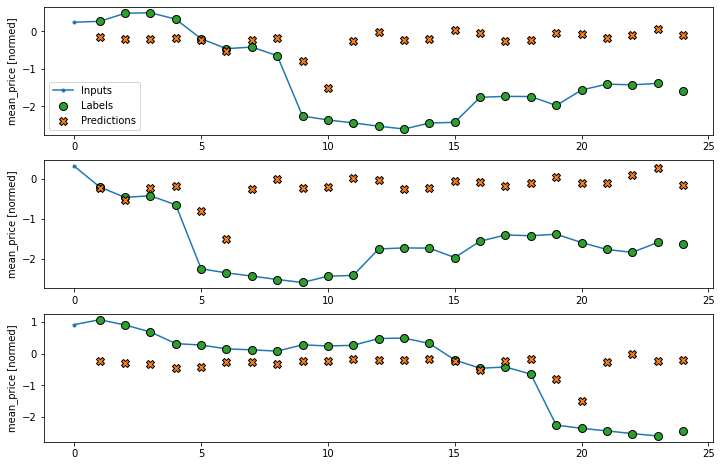

In [ ]:
wide_window.plot(linear)

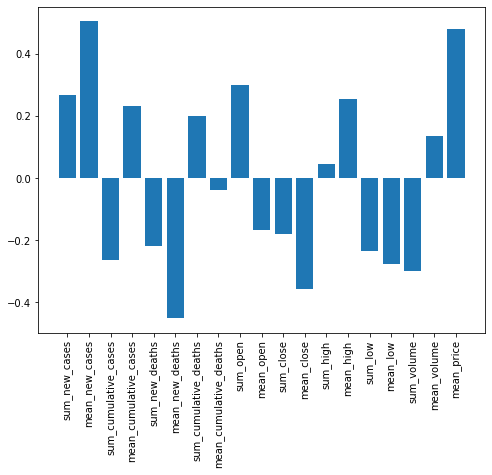

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#Dense model

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
25/25 [==============================] - 0s 10ms/step - loss: 0.3671 - mean_absolute_error: 0.4305 - val_loss: 0.2091 - val_mean_absolute_error: 0.4100
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0522 - mean_absolute_error: 0.1660 - val_loss: 0.4208 - val_mean_absolute_error: 0.5208
Epoch 3/20
7/7 [==============================] - 0s 1ms/step - loss: 0.4700 - mean_absolute_error: 0.5189


In [ ]:
CONV_WIDTH = 24
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['mean_price'])

conv_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['mean_price']

Text(0.5, 1.0, 'Given 14 days as input, predict 1 day into the future.')

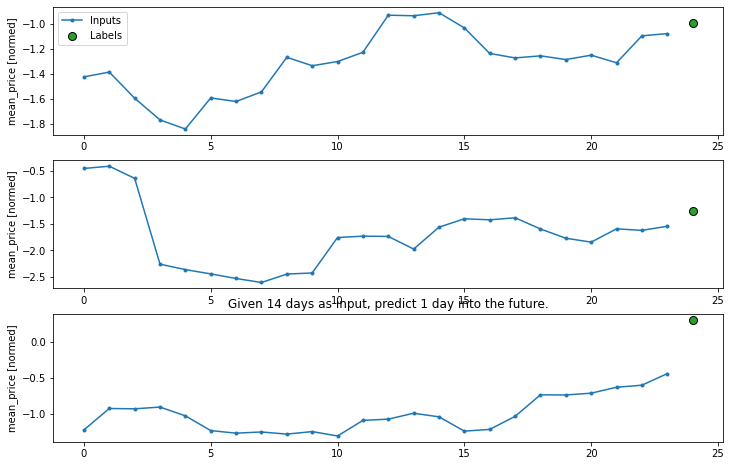

In [ ]:
conv_window.plot()
plt.title("Given 14 days as input, predict 1 day into the future.")

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (7, 24, 19)
Output shape: (7, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

4/4 [==============================] - 0s 2ms/step - loss: 1.1747 - mean_absolute_error: 0.9992


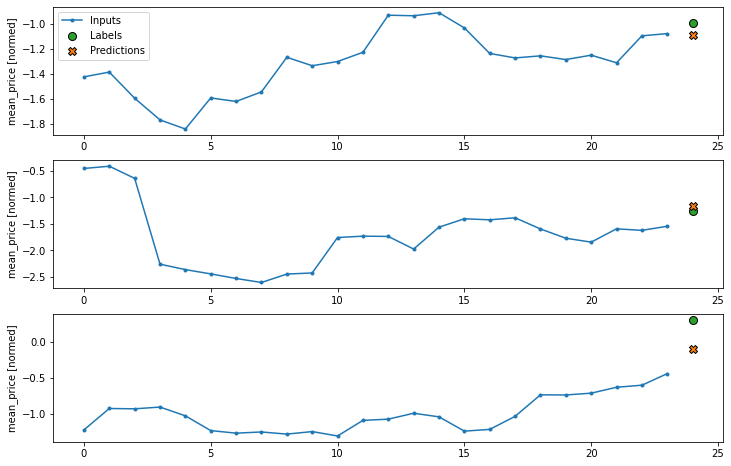

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (7, 24, 19)
Output shape: (7, 1, 1)


#Convolution neural network

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (7, 24, 19)
Output shape: (7, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

4/4 [==============================] - 0s 2ms/step - loss: 0.9992 - mean_absolute_error: 0.9791


In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (7, 24, 19)
Labels shape: (7, 24, 1)
Output shape: (7, 1, 1)


In [ ]:
LABEL_WIDTH = 24 #poli changed from 24 to 7 
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['mean_price'])

wide_conv_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['mean_price']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (7, 47, 19)
Labels shape: (7, 24, 1)
Output shape: (7, 24, 1)


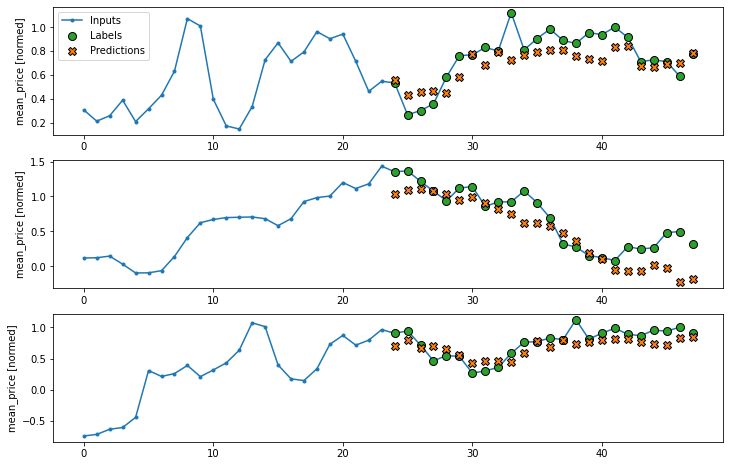

In [ ]:
wide_conv_window.plot(conv_model)

#LSTM itself

**Part1:** Running LSTM on bitcoin + Covid-19 dataset

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(50, return_sequences=True),  ##Poli changed from 32 to 10 to 32
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (7, 24, 19)
Output shape: (7, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 3ms/step - loss: 1.5670 - mean_absolute_error: 0.9520


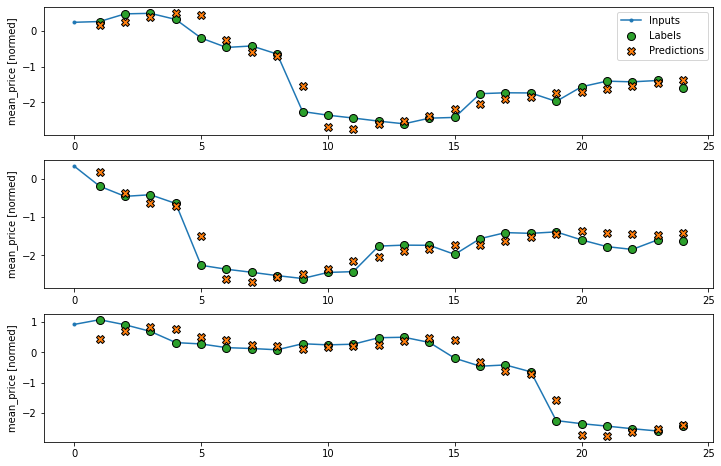

In [ ]:
wide_window.plot(lstm_model)

#**Part 2**: LSTM on bitcoin data only (without COVID-19)


In [ ]:
df.head()

,sum_open,mean_open,sum_close,mean_close,sum_high,mean_high,sum_low,mean_low,sum_volume,mean_volume
0,1.155771e+07,8026.185221,1.155732e+07,8025.913318,1.156170e+07,8028.955982,1.155310e+07,8022.987117,9277.814487,6.442927
1,1.125633e+07,7816.897796,1.125624e+07,7816.835135,1.125929e+07,7818.948853,1.125331e+07,7814.797290,5054.642417,3.510168
2,1.160109e+07,8061.907943,1.160120e+07,8061.987280,1.160525e+07,8064.805258,1.159688e+07,8058.987007,7423.894835,5.159065
3,1.165830e+07,8096.039051,1.165836e+07,8096.081200,1.166053e+07,8097.590995,1.165605e+07,8094.479811,3561.372111,2.473175
4,1.168059e+07,8111.518408,1.168053e+07,8111.475775,1.168213e+07,8112.589977,1.167902e+07,8110.431047,3266.132200,2.268147


In [ ]:
##removing Covid data
df = pd.read_csv('https://raw.githubusercontent.com/PoliNemkova/crypto/5aa17c1d623cff982ecc6f52330c2bfb0c790b7e/bitcoin-covid19.csv')
df=df.drop(['sum_new_cases','mean_new_cases','sum_cumulative_cases','mean_cumulative_cases','sum_new_deaths','mean_new_deaths','sum_cumulative_deaths', 'mean_cumulative_deaths' ], axis=1)


In [ ]:
#dropping non sensitive features
df=df.drop(['date','skew_volume','kurt_volume','skew_low','kurt_low','kurt_high', 'skew_high', 'kurt_close',
       'skew_close','kurt_open', 'skew_open','kurt_cumulative_deaths',
       'skew_cumulative_deaths', 'kurt_new_deaths', 'skew_new_deaths',  'kurt_cumulative_cases',
       'skew_cumulative_cases', 'kurt_new_cases', 'skew_new_cases'], axis=1)

In [ ]:
df.head()

,sum_open,mean_open,sum_close,mean_close,sum_high,mean_high,sum_low,mean_low,sum_volume,mean_volume
0,1.155771e+07,8026.185221,1.155732e+07,8025.913318,1.156170e+07,8028.955982,1.155310e+07,8022.987117,9277.814487,6.442927
1,1.125633e+07,7816.897796,1.125624e+07,7816.835135,1.125929e+07,7818.948853,1.125331e+07,7814.797290,5054.642417,3.510168
2,1.160109e+07,8061.907943,1.160120e+07,8061.987280,1.160525e+07,8064.805258,1.159688e+07,8058.987007,7423.894835,5.159065
3,1.165830e+07,8096.039051,1.165836e+07,8096.081200,1.166053e+07,8097.590995,1.165605e+07,8094.479811,3561.372111,2.473175
4,1.168059e+07,8111.518408,1.168053e+07,8111.475775,1.168213e+07,8112.589977,1.167902e+07,8110.431047,3266.132200,2.268147


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(50, return_sequences=True),  ##Poli changed from 32 to 10
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (10, 24, 19)
Output shape: (10, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

3/3 [==============================] - 0s 3ms/step - loss: 1.5896 - mean_absolute_error: 0.9400


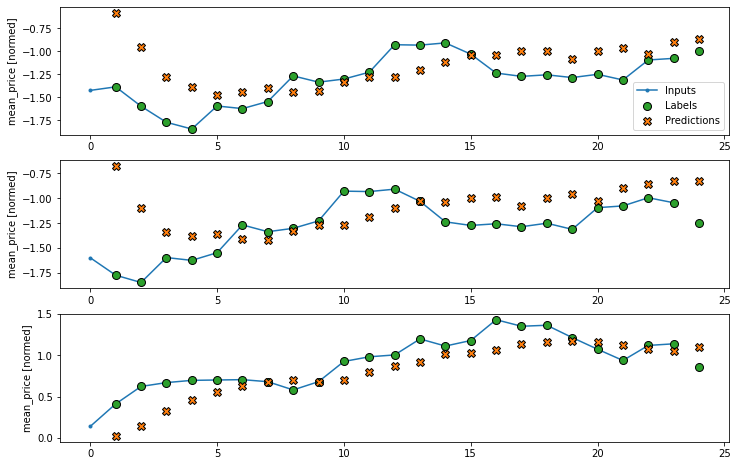

In [ ]:
wide_window.plot(lstm_model)

#PERFOMANCE

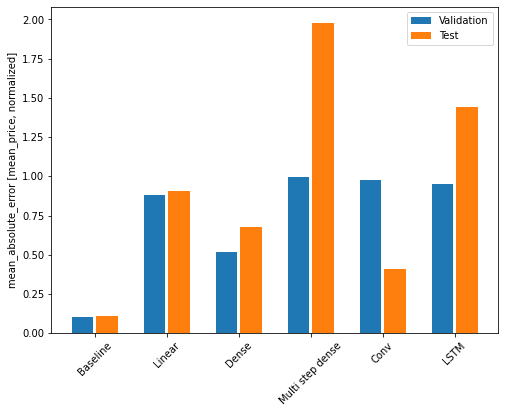

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [mean_price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1093
Linear      : 0.9089
Dense       : 0.6769
Multi step dense: 1.9796
Conv        : 0.4105
LSTM        : 1.4419


Baseline    : 0.1093
Linear      : 0.1320
Dense       : 0.2073
Multi step dense: 0.2466
Conv        : 0.1522
LSTM        : 0.4378

#Multiple parameters

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (10, 24, 19)
Labels shape (batch, time, features): (10, 24, 19)


In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
#RNN
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

3/3 [==============================] - 0s 3ms/step - loss: 2.0937 - mean_absolute_error: 1.0881

CPU times: user 8.51 s, sys: 505 ms, total: 9.02 s
Wall time: 7.26 s


In [ ]:
#Residual connections
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

3/3 [==============================] - 0s 3ms/step - loss: 0.0753 - mean_absolute_error: 0.1655

CPU times: user 4.35 s, sys: 224 ms, total: 4.58 s
Wall time: 4.08 s


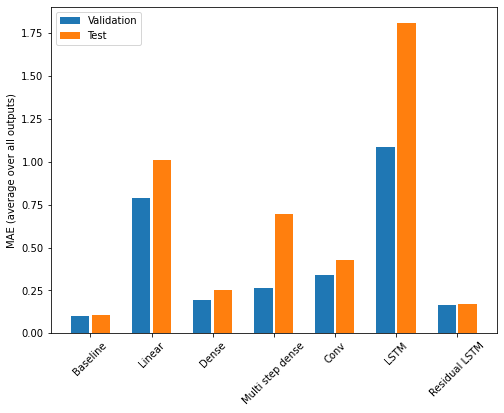

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1093
Linear         : 1.0123
Dense          : 0.2537
Multi step dense: 0.6975
Conv           : 0.4287
LSTM           : 1.8128
Residual LSTM  : 0.1705


Multi-step models

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): None

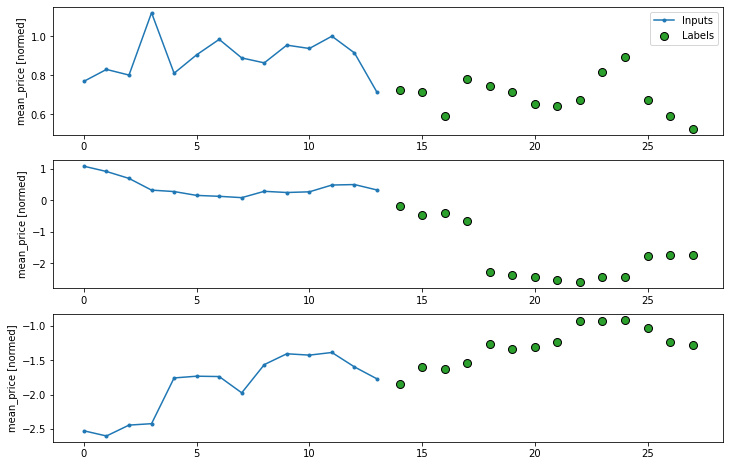

In [ ]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Baselines

3/3 [==============================] - 0s 1ms/step - loss: 0.5731 - mean_absolute_error: 0.5783


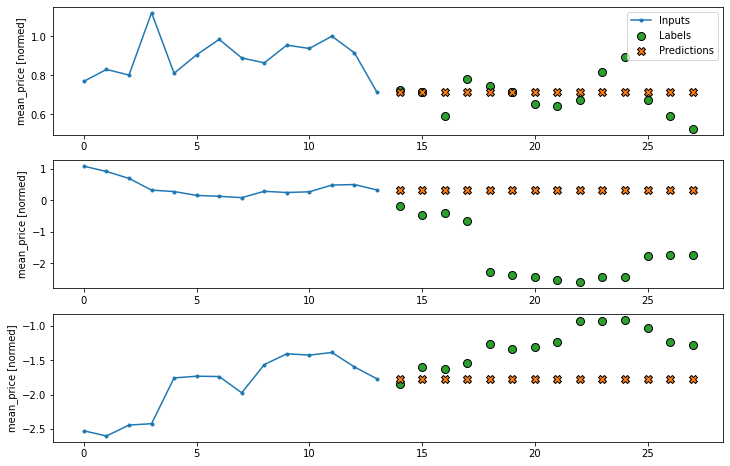

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

3/3 [==============================] - 0s 3ms/step - loss: 1.0301 - mean_absolute_error: 0.8424


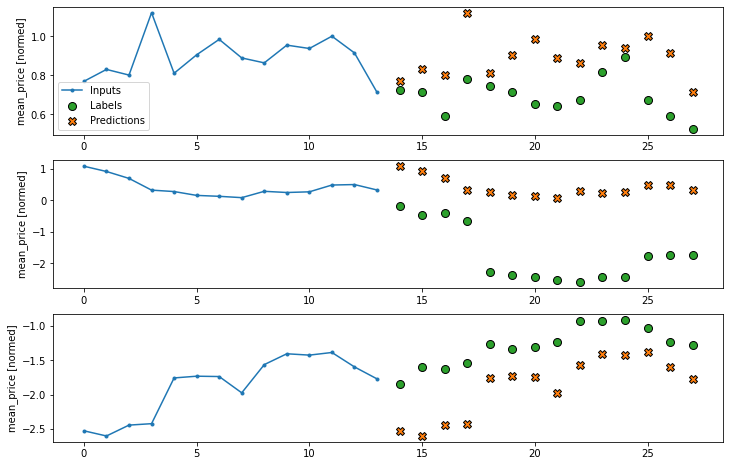

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

autoregressive RNN

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([10, 19])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (10, 14, 19)


3/3 [==============================] - 0s 3ms/step - loss: 3.1791 - mean_absolute_error: 1.4319


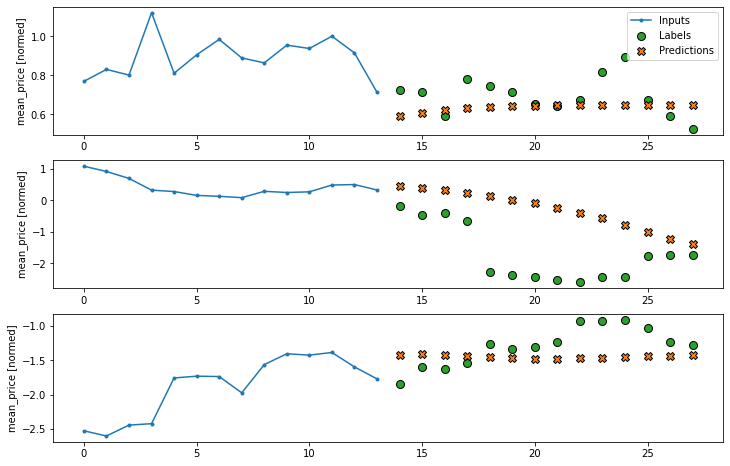

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

TypeError: ignored

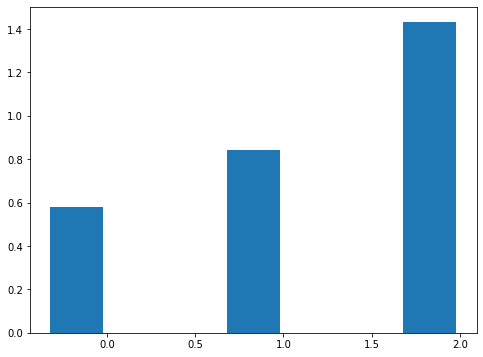

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()